In [1]:
import pandas as pd
from pathlib import Path

from biothings_client import get_client
from hetnet_ml.src import graph_tools as gt
from tools.hetnet_file_processing import read_reactome
from tools.processing import regularize_colnames, head, expand_col_on_char, combine_group_rows_on_char

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

load_dir = Path('../2_pipeline/00_download_data/out/').resolve()
network_dir = load_dir.parent.parent.joinpath('06_GO_regulation_nodes_into_edges/out')
tax_dir = load_dir.parent.parent.joinpath('07_Taxonomic_cause_of_disease/out')

In [2]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')
// hack to get the filename for this notebook

<IPython.core.display.Javascript object>

In [3]:
out_dir = Path('../2_pipeline/').joinpath(nb_name.split('.')[0]).joinpath('out').resolve()
out_dir.mkdir(parents=True, exist_ok=True)

In [4]:
all_nodes = gt.remove_colons(pd.read_csv(network_dir.joinpath('nodes_all.csv'), dtype=str))
edges = gt.remove_colons(pd.read_csv(network_dir.joinpath('edges.csv'), dtype=str))

In [5]:
all_nodes.head(2)

,id,name,label,tree_numbers,drug_bank_ids,alt_disease_ids,gene_symbol,alt_gene_ids,bio_gridids,pharm_gkbids,uni_prot_ids,uniprot_id,mesh_ids,chebi_ids
0,MESH:C089250,(0.017ferrocene)amylose,Compound,D01.490.200/C089250|D02.691.550.200/C089250|D0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MESH:C114385,001-C8-NBD,Compound,D03.383.129.462.580/C114385|D12.644.456/C114385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Lets look at the taxa that are in our diseases...

In [6]:
tax_nodes = pd.read_csv(tax_dir.joinpath('new_nodes.csv')).query('label == "Taxonomy"')
tax_nodes.head(2)

,id,name,label,alt_disease_ids
0,NCBITaxon:71585,Balantioides coli,Taxonomy,NaN
1,NCBITaxon:11308,Orthomyxoviridae,Taxonomy,NaN


In [7]:
tax_ids = tax_nodes['id'].str.split(':', expand=True)[1].astype(int).tolist()

In [8]:
mt = get_client('taxon')

all_infectious_taxa = set([i for t in mt.gettaxa(tax_ids) for i in t.get('lineage', [])])
all_infectious_taxa = all_infectious_taxa | set(tax_ids)

querying 1-240...done.


In [9]:
all_infectious_taxa = [str(t) for t in all_infectious_taxa]

In [10]:
edges.head(2)

,start_id,end_id,type,parent_ixn,pub_med_ids,organism_id,abbv,source,evidence,direct_evidence,corrected_pvalue,inference_gene_symbol,qualifier,db_reference,evidence_code,with_or_from,date,assigned_by,experiments,support_type
0,MESH:C000121,4313,decreases_activity_CdaG,decreases^activity,25899827,9606,CdaG,CTD,curated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MESH:C000121,4313,decreases_expression_CdeG,decreases^expression,25899827,9606,CdeG,CTD,curated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
tax_edges = edges[~edges['organism_id'].isnull()]
print('Edges with a taxonomic marker: {:,}'.format(len(tax_edges)))
human_edges = tax_edges[tax_edges['organism_id'].str.contains('9606')]
print('Edges with a human taxonomic marker: {:,}'.format(len(human_edges)))
infectious_tax_edges = tax_edges.query('organism_id in @all_infectious_taxa')
print('Edges with a taxon marker in our current disease set: {:,}'.format(len(infectious_tax_edges)))

Edges with a taxonomic marker: 1,177,656
Edges with a human taxonomic marker: 508,620
Edges with a taxon marker in our current disease set: 2,549


A little over half of the edges will be removed...

In [14]:
hmn_idx = human_edges.index
inf_idx = infectious_tax_edges.index

In [22]:
drop_idx = ~tax_edges.index.isin(hmn_idx.union(inf_idx))

tax_edges[drop_idx].sample(20)

,start_id,end_id,type,parent_ixn,pub_med_ids,organism_id,abbv,source,evidence,direct_evidence,corrected_pvalue,inference_gene_symbol,qualifier,db_reference,evidence_code,with_or_from,date,assigned_by,experiments,support_type
1066015,MESH:D037742,55278,decreases_expression_CdeG,decreases^expression,25620056,10090,CdeG,CTD,curated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3188501,MESH:D004052,GO:1903409,decreases_reaction_CdrBP,decreases^reaction,30423403,10116,CdrBP,CTD,curated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
249880,MESH:C045950,80765,decreases_expression_CdeG,decreases^expression,21278054,10090,CdeG,CTD,curated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
853309,MESH:D013749,5954,affects_expression_CaeG,affects^expression,20702594,10090,CaeG,CTD,curated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
920212,MESH:D014635,5239,affects_expression_CaeG,affects^expression,17963808,10090,CaeG,CTD,curated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
887758,MESH:D014028,1524,affects_expression_CaeG,affects^expression,20133372,10090,CaeG,CTD,curated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
771481,MESH:D010634,9559,increases_expression_CieG,increases^expression,19162173,10116,CieG,CTD,curated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
562004,MESH:D003520,5888,decreases_expression_CdeG,decreases^expression,21041162,10090,CdeG,CTD,curated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241087,MESH:C042670,6929,increases_expression_CieG,increases^expression,22037397,10116,CieG,CTD,curated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356958,MESH:C517733,6261,increases_activity_CiaG,increases^activity,30329129,10090,CiaG,CTD,curated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
edges = edges.drop(tax_edges[drop_idx].index)

In [24]:
'{:,}'.format(len(edges))

'5,855,465'

In [25]:
edge_ids = edges[['start_id', 'end_id']].stack().unique()

In [26]:
print('{:,}'.format(len(all_nodes)))
filt_nodes = all_nodes.query('id in @edge_ids')
print('{:,}'.format(len(filt_nodes)))

789,028
104,278


In [27]:
filt_node_ids = filt_nodes['id'].unique()
print('{:,}'.format(len(edges)))
print('{:,}'.format(len(edges.query('start_id in @filt_node_ids and end_id in @filt_node_ids'))))

5,855,465
5,855,465


# Plot some interesing characterisitcs

In [29]:
colors = sns.color_palette(["#4f8c9d", "#e23209", "#77be20", "#a34ddf", "#34f50e", "#871d32", "#18d19b"])
c_mapper = {n: i for i, n in enumerate(filt_nodes['label'].unique())}

In [30]:
filt_nodes['label'].nunique()

11

In [31]:
combo = gt.combine_nodes_and_edges(filt_nodes, edges)

In [32]:
def plot_avg_deg_for_kind(kind):

    this_edges = combo.query('start_label == @kind or end_label == @kind')
    avg_deg = this_edges['type'].value_counts() / filt_nodes['label'].value_counts()[kind]
    avg_deg = avg_deg.reset_index()

    n_edges = len(avg_deg)
    
    fig, ax = plt.subplots()
    fig.set_size_inches(6, 4+int(n_edges / 6))

    sns.barplot(x='type', y='index', data=avg_deg, color=colors[c_mapper[kind]], ax=ax)
    plt.xlabel('Average degree')
    plt.ylabel('Edge Type')
    plt.title('Average Degree by edge type in {}'.format(kind));

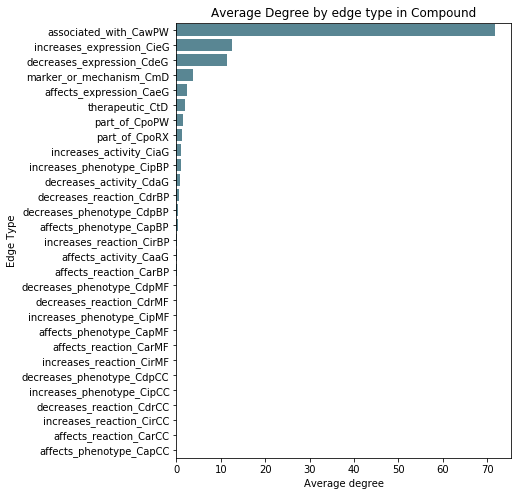

In [33]:
plot_avg_deg_for_kind('Compound')

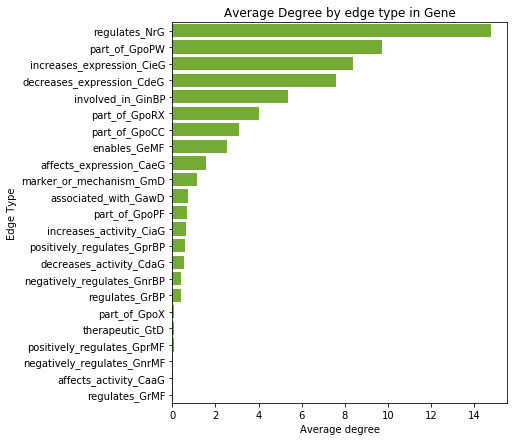

In [34]:
plot_avg_deg_for_kind('Gene')

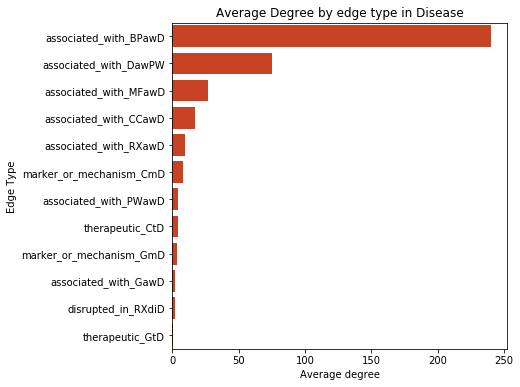

In [35]:
plot_avg_deg_for_kind('Disease')

# More plotting

In [36]:
from tqdm import tqdm
tqdm.pandas()

In [37]:
combo[['direction', 'action']] = combo['parent_ixn'].str.split('^', expand=True)

In [38]:
combo.head(2)

,start_id,end_id,type,parent_ixn,pub_med_ids,organism_id,abbv,source,evidence,direct_evidence,...,date,assigned_by,experiments,support_type,start_name,end_name,start_label,end_label,direction,action
0,MESH:C000121,4313,decreases_activity_CdaG,decreases^activity,25899827,9606,CdaG,CTD,curated,NaN,...,NaN,NaN,NaN,NaN,pipoxolan,matrix metallopeptidase 2,Compound,Gene,decreases,activity
1,MESH:C000121,4313,decreases_expression_CdeG,decreases^expression,25899827,9606,CdeG,CTD,curated,NaN,...,NaN,NaN,NaN,NaN,pipoxolan,matrix metallopeptidase 2,Compound,Gene,decreases,expression


In [39]:
data = combo.query('start_label == "Compound" and end_label == "Gene"')
data = data.groupby(['start_id', 'end_id', 'action'])
data = data['direction'].progress_apply(lambda c: ', '.join([s.capitalize() for s in c]))

100%|██████████| 443765/443765 [00:50<00:00, 8719.96it/s]


In [40]:
data = data.reset_index()
data.head(2)

,start_id,end_id,action,direction
0,MESH:C000121,4313,activity,Decreases
1,MESH:C000121,4313,expression,Decreases


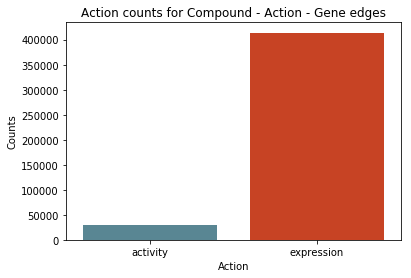

In [41]:
sns.countplot(x='action', data=data, palette=colors)
plt.xlabel('Action')
plt.ylabel('Counts')
plt.title('Action counts for Compound - Action - Gene edges');

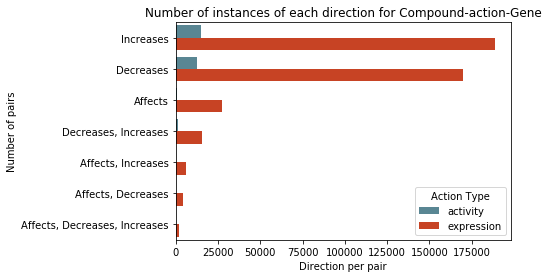

In [42]:
order = data['direction'].value_counts().index.tolist()
sns.countplot(y='direction', data=data, hue='action', order=order, palette=colors)
plt.xlabel('Direction per pair')
plt.ylabel('Number of pairs')
plt.legend(title='Action Type')
plt.title('Number of instances of each direction for Compound-action-Gene');

In [43]:
test = combo.query('start_label == "Compound" and end_label == "Gene"')
test = test.groupby(['start_id', 'end_id', 'direction'])
test = test['action'].progress_apply(lambda c: ', '.join([s.capitalize() for s in c]))

100%|██████████| 469304/469304 [00:53<00:00, 8708.52it/s]


In [44]:
test = test.reset_index()
test.head(2)

,start_id,end_id,direction,action
0,MESH:C000121,4313,decreases,"Activity, Expression"
1,MESH:C000121,4318,decreases,"Activity, Expression"


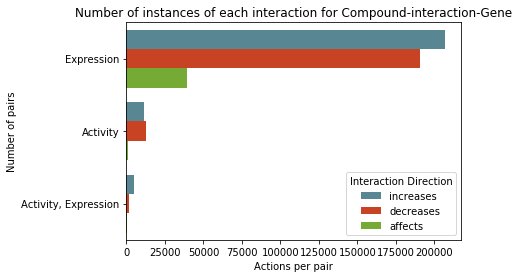

In [45]:
order = ['Expression', 'Activity', 'Activity, Expression']
h_order = ['increases', 'decreases', 'affects']

sns.countplot(y='action', data=test, hue='direction', order=order, hue_order=h_order, palette=colors)
plt.xlabel('Actions per pair')
plt.ylabel('Number of pairs')
plt.legend(title='Interaction Direction')
plt.title('Number of instances of each interaction for Compound-interaction-Gene');

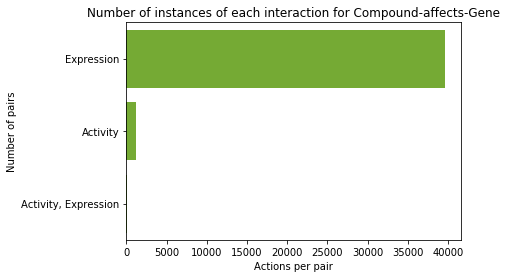

In [46]:
sns.countplot(y='action', data=test.query('direction == "affects"'), color=colors[2])
plt.xlabel('Actions per pair')
plt.ylabel('Number of pairs')
plt.title('Number of instances of each interaction for Compound-affects-Gene');

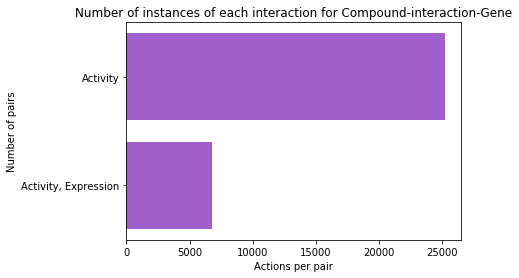

In [47]:
sns.countplot(y='action', data=test.query('action != "Expression"'), order=order[1:], color=colors[3])
plt.xlabel('Actions per pair')
plt.ylabel('Number of pairs')
plt.title('Number of instances of each interaction for Compound-interaction-Gene');

# Similar Analysis on compounds to GO-Terms

In [48]:
def group_terms(combo_df, start_type, end_type, group_on, count_col):
    data = combo_df.query('start_label == @start_type and end_label == @end_type')
    data = data.groupby(['start_id', 'end_id', group_on])
    data = data[count_col].progress_apply(lambda c: ', '.join([s.capitalize() for s in c]))
    return data.reset_index()

In [49]:
bp_directions = group_terms(combo, 'Compound', 'Biological Process', 'action', 'direction')

100%|██████████| 38462/38462 [00:04<00:00, 8647.10it/s]


In [50]:
bp_directions.head()

,start_id,end_id,action,direction
0,MESH:C000121,GO:0008283,phenotype,Decreases
1,MESH:C000121,GO:0016477,phenotype,Decreases
2,MESH:C000152,GO:0006702,phenotype,Decreases
3,MESH:C000152,GO:0008284,phenotype,"Decreases, Increases"
4,MESH:C000152,GO:0008284,reaction,Decreases


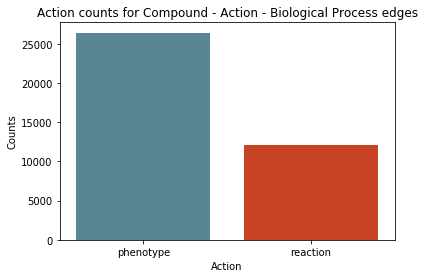

In [51]:
sns.countplot(x='action', data=bp_directions, palette=colors)
plt.xlabel('Action')
plt.ylabel('Counts')
plt.title('Action counts for Compound - Action - Biological Process edges');

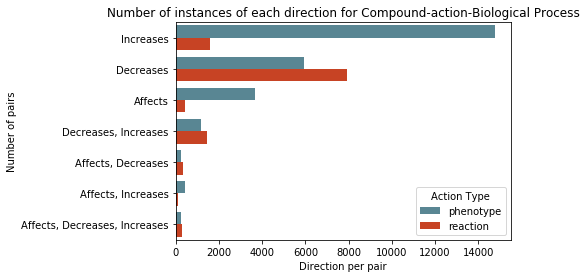

In [52]:
order = bp_directions['direction'].value_counts().index.tolist()
sns.countplot(y='direction', data=bp_directions, hue='action', order=order, palette=colors)
plt.xlabel('Direction per pair')
plt.ylabel('Number of pairs')
plt.legend(title='Action Type')
plt.title('Number of instances of each direction for Compound-action-Biological Process');

In [53]:
bp_actions = group_terms(combo, 'Compound', 'Biological Process', 'direction', 'action')
bp_actions.head(2)

100%|██████████| 37882/37882 [00:04<00:00, 8563.24it/s]


,start_id,end_id,direction,action
0,MESH:C000121,GO:0008283,decreases,Phenotype
1,MESH:C000121,GO:0016477,decreases,Phenotype


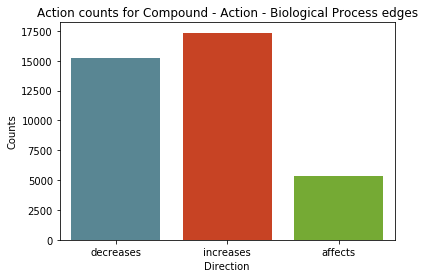

In [54]:
sns.countplot(x='direction', data=bp_actions, palette=colors)
plt.xlabel('Direction')
plt.ylabel('Counts')
plt.title('Action counts for Compound - Action - Biological Process edges');

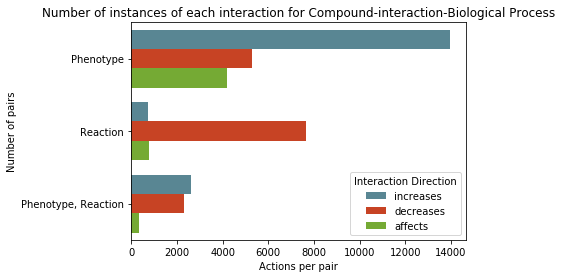

In [55]:
h_order = ['increases', 'decreases', 'affects']
order = bp_actions['action'].value_counts().index.tolist()

sns.countplot(y='action', data=bp_actions, hue='direction', order=order, hue_order=h_order, palette=colors)
plt.xlabel('Actions per pair')
plt.ylabel('Number of pairs')
plt.legend(title='Interaction Direction')
plt.title('Number of instances of each interaction for Compound-interaction-Biological Process');

# Save to Disk

In [56]:
gt.add_colons(all_nodes, id_name='identifier').to_csv(out_dir.joinpath('nodes_all.csv'), index=False)
gt.add_colons(filt_nodes, id_name='identifier').to_csv(out_dir.joinpath('nodes_filt.csv'), index=False)

gt.add_colons(edges).to_csv(out_dir.joinpath('edges.csv'), index=False)